In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as lm
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import seaborn as sns

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Set the random seed for reproducibility
np.random.seed(2417)


# Part Two
(Part one comes after Part two)

## Case I

In [2]:
class PCR(object):

    def __init__(self, num_folds=10):
        self.folds = num_folds

    def fit(self, X, Y):
        n, p = X.shape
        indices = np.arange(n)
        np.random.shuffle(indices)
        index_sets = np.array_split(indices, self.folds)
        ncomp = min(p, n - 1 - max([len(i) for i in index_sets]))
        cv_err = np.zeros(ncomp)

        for ifold in range(self.folds):
            train_inds =  np.delete(index_sets, obj=ifold, axis=0).ravel()
            test_inds = index_sets[ifold]

            X_train = X[train_inds, :]
            pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA())])
            pipeline.fit(X_train)
            X_train = pipeline.transform(X_train)
            coefs = Y[train_inds].T @ X_train / np.sum(X_train**2, axis=0)
            b0 = np.mean(Y[train_inds])

            X_test = pipeline.transform(X[test_inds, :])

            for k in np.arange(ncomp):
                preds = X_test[:, :k] @ coefs.T[:k] + b0
                cv_err[k] += cv_err[k] + np.sum((Y[test_inds]-preds)**2)

        min_ind = np.argmin(cv_err)
        self.ncomp = min_ind+1
        pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=self.ncomp))])
        self.transform = pipeline.fit(X)
        self.model = lm().fit(self.transform.transform(X), Y)

    def predict(self, X):
        X_ = self.transform.transform(X)
        return self.model.predict(X_)

In [3]:
myData = pd.read_csv("Coding2_Data2.csv")
# myData.head()
Y = myData['Y']
X = myData.drop(['Y'], axis = 1)
X.shape, len(Y)

((506, 91), 506)

In [4]:
numIteration  = 50
mspe_full = np.zeros(numIteration)
mspe_ridge = np.zeros(numIteration)
mspe_lasso_min = np.zeros(numIteration)
mspe_lasso_1se = np.zeros(numIteration)
mspe_lasso_refit = np.zeros(numIteration)
mspe_pcr = np.zeros(numIteration)

optimal_ridge_alpha = np.zeros(numIteration)
optimal_lasso_min = np.zeros(numIteration)
optimal_lasso_1se = np.zeros(numIteration)

for i in  tqdm(range(numIteration)):

    # Step 0: Splitting the data into training and testing sets

    lenData = len(Y)

    indices = np.arange(0, lenData)
    np.random.shuffle(indices)
    test_ind = indices[:int(np.floor(0.25*lenData))]
    train_ind = indices[len(test_ind):]

    X_train = X.iloc[train_ind]
    Y_train = Y[train_ind]
    X_test = X.iloc[test_ind]
    Y_test = Y[test_ind]
    
    ## Normalize X 
    scaler = StandardScaler()
    X_train_tmp = scaler.fit_transform(X_train)
    X_test_tmp = scaler.fit_transform(X_test)
    
    X_train_scaled = pd.DataFrame(X_train_tmp, columns = X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_tmp, columns = X_test.columns)

    # Step 1: Full model
    
    full = lm().fit(X_train_scaled, Y_train)
    mspe_full[i] = mean_squared_error(Y_test, full.predict(X_test_scaled))
    
    # Step 2: Ridge Regression
    
    ridge_alphas = np.logspace(-10, 1, 100)
    ridgecv = RidgeCV(alphas = ridge_alphas, cv = 10, 
                      scoring = 'neg_mean_squared_error')
    ridgecv.fit(X_train_scaled, Y_train)
    optimal_ridge_alpha[i] = ridgecv.alpha_
    
    ridge_model = Ridge(alpha = ridgecv.alpha_)
    ridge_model.fit(X_train_scaled, Y_train)
    mspe_ridge[i] = mean_squared_error(Y_test, ridge_model.predict(X_test_scaled))
    
    # Step 3: Lasso using lambda.min
    
    lasso_alphas = np.logspace(-10, 1, 100)
    lassocv = LassoCV(alphas = lasso_alphas, cv = 10)
    lassocv.fit(X_train_scaled, Y_train)

    mean_mse = np.mean(lassocv.mse_path_, axis=1)
    std_mse = np.std(lassocv.mse_path_, axis=1) / np.sqrt(10) 

    cv_alphas = lassocv.alphas_
    min_idx = np.argmin(mean_mse)
    alpha_min = cv_alphas[min_idx]

    threshold = mean_mse[min_idx] + std_mse[min_idx]
    alpha_1se = max(cv_alphas[np.where(mean_mse <= threshold)])

    optimal_lasso_min[i] = alpha_min
    optimal_lasso_1se[i] = alpha_1se
    
    ## Lasso with lambda.min
    lasso_model_min = Lasso(alpha = alpha_min, max_iter=10000)
    lasso_model_min.fit(X_train_scaled, Y_train)
    mspe_lasso_min[i] = mean_squared_error(Y_test, lasso_model_min.predict(X_test_scaled))
    
    # Step 4: Lasso using lambda.1se
    lasso_model_1se = Lasso(alpha = alpha_1se,  max_iter=10000)
    lasso_model_1se.fit(X_train_scaled, Y_train)
    mspe_lasso_1se[i] = mean_squared_error(Y_test, lasso_model_1se.predict(X_test_scaled))
    
    # Step 5: Refit with alpha_1se
    nonzero_indices = np.where(lasso_model_1se.coef_ != 0)[0]
    lm_refit = lm()
    lm_refit.fit(X_train_scaled.iloc[:, nonzero_indices], Y_train)
    mspe_lasso_refit[i] = mean_squared_error(Y_test, lm_refit.predict(X_test_scaled.iloc[:, nonzero_indices]))
    
    # Step 6: PCR
    pcr = PCR()
    pcr.fit(X_train_scaled.to_numpy(), Y_train.to_numpy())
    mspe_pcr[i] = mean_squared_error(Y_test, pcr.predict(X_test_scaled.to_numpy()))

100%|███████████████████████████████████████████| 50/50 [06:22<00:00,  7.65s/it]


In [5]:
data = [mspe_full, mspe_ridge, mspe_lasso_min, mspe_lasso_1se, mspe_lasso_refit, mspe_pcr ]
labels = ['Full', 'Ridge', 'Lasso-min', 'Lasso-1se', 'Lasso-refit', 'PCR']

data_convert = np.array(data).T

df = pd.DataFrame(data_convert, columns=labels)
df.to_csv('mspe.csv')

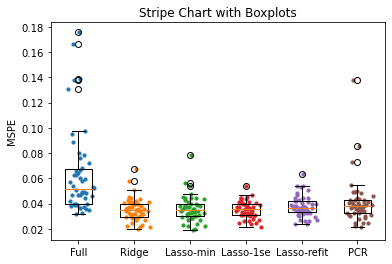

In [8]:
# data_convert = pd.read_csv("mspe.csv").to_numpy()
# labels = ['Ridge', 'Lasso-min', 'Lasso-1se', 'Lasso-refit', 'PCR']
# numIteration = 50

fig, ax = plt.subplots()

x0 = [1] * numIteration + np.random.normal(0,0.1,numIteration)

# Plot stripe charts for each set
for i in range(6):
    plt.scatter(x0+i, data_convert[:,i], marker='o', s = 10)
plt.boxplot(data_convert,vert=True)

ax.set_ylabel('MSPE')
ax.set_xticks(range(1,7))
ax.set_xticklabels(labels[0:6])
ax.set_title('Stripe Chart with Boxplots')

plt.show()


In [11]:
mean_mspe = data_convert.mean(0)
print(mean_mspe)
std_mspe = data_convert.std(0)
print(std_mspe)

[0.06323761 0.03525288 0.03575053 0.03529928 0.0377481  0.04071292]
[0.03338297 0.00883952 0.01003911 0.00651587 0.00811823 0.01780213]


#### 1. Which procedure or procedures yield the best performance in terms of MSPE?
In terms of MSPE, Lasso-1se demonstrates the best performance as it has the second smallest mean and the smallest standard deviation.

#### 2. Conversely, which procedure or procedures show the poorest performance?

From the stripe chart, it is evident that the full model exhibits the poorest performance, with the broadest MSPE distribution and multiple outliers that are notably distant from the rest of the data.

#### 3. In the context of Lasso regression, which procedure, Lasso.min or Lasso.1se, yields a better MSPE?
Between Lasso-min and Lasso-1se, Lasso-1se yields slightly better MSPE on average, but the difference is not very pronounced.

#### 4. Is refitting advantageous in this case? In other words, does L.Refit outperform Lasso.1se?
Speaking of MSPE, Lasso-refit is not remarkably better than Lasso-1se.

#### 5. Is variable selection or shrinkage warranted for this particular dataset? To clarify, do you find the performance of the Full model to be comparable to, or divergent from, the best-performing procedure among the other five?
Comparing the MSPE derived from the six methods indicates that variable selection significantly enhances prediction performance. These variable selection methods address overfitting and multicollinearity issues in the linear regression model, which has plenty of predictors, resulting in a more robust and accurate prediction model.

## Case II

In [12]:
myData2 = pd.read_csv("Coding2_Data3.csv")
# myData.head()
Y2 = myData2['Y']
X2 = myData2.drop(['Y'], axis = 1)
X2.shape, len(Y2)


((506, 591), 506)

In [13]:
mspe_ridge_case2 = np.zeros(numIteration)
mspe_lasso_min_case2 = np.zeros(numIteration)
mspe_lasso_1se_case2 = np.zeros(numIteration)
mspe_lasso_refit_case2 = np.zeros(numIteration)
mspe_pcr_case2 = np.zeros(numIteration)

optimal_ridge_alpha_case2 = np.zeros(numIteration)
optimal_lasso_min_case2 = np.zeros(numIteration)
optimal_lasso_1se_case2 = np.zeros(numIteration)

for i in tqdm(range(numIteration)):

    # Step 0: Splitting the data into training and testing sets

    lenData = len(Y2)

    indices = np.arange(0, lenData)
    np.random.shuffle(indices)
    test_ind = indices[:int(np.floor(0.25*lenData))]
    train_ind = indices[len(test_ind):]

    X_train = X2.iloc[train_ind]
    Y_train = Y2[train_ind]
    X_test = X2.iloc[test_ind]
    Y_test = Y2[test_ind]
    
    scaler = StandardScaler()
    X_train_tmp = scaler.fit_transform(X_train)
    X_test_tmp = scaler.fit_transform(X_test)
    
    X_train_scaled = pd.DataFrame(X_train_tmp, columns = X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_tmp, columns = X_test.columns)
    
    # Step 1: Ridge Regression
    
    ridge_alphas = np.logspace(-10, 1, 100)
    ridgecv = RidgeCV(alphas = ridge_alphas, cv = 10, 
                      scoring = 'neg_mean_squared_error')
    ridgecv.fit(X_train_scaled, Y_train)
    optimal_ridge_alpha_case2[i] = ridgecv.alpha_
    
    ridge_model = Ridge(alpha = ridgecv.alpha_)
    ridge_model.fit(X_train_scaled, Y_train)
    mspe_ridge_case2[i] = mean_squared_error(Y_test, ridge_model.predict(X_test_scaled))
    
    # Step 2: Lasso using lambda.min
    
    lasso_alphas = np.logspace(-10, 1, 100)
    lassocv = LassoCV(alphas = lasso_alphas, cv = 10)
    lassocv.fit(X_train_scaled, Y_train)

    mean_mse = np.mean(lassocv.mse_path_, axis=1)
    std_mse = np.std(lassocv.mse_path_, axis=1) / np.sqrt(10) 

    cv_alphas = lassocv.alphas_
    min_idx = np.argmin(mean_mse)
    alpha_min = cv_alphas[min_idx]

    threshold = mean_mse[min_idx] + std_mse[min_idx]
    alpha_1se = max(cv_alphas[np.where(mean_mse <= threshold)])

    optimal_lasso_min_case2[i] = alpha_min
    optimal_lasso_1se_case2[i] = alpha_1se
    
    ## Lasso with lambda.min
    lasso_model_min = Lasso(alpha = alpha_min, max_iter=10000)
    lasso_model_min.fit(X_train_scaled, Y_train)
    mspe_lasso_min_case2[i] = mean_squared_error(Y_test, lasso_model_min.predict(X_test_scaled))
    
    # Step 3: Lasso using lambda.1se
    lasso_model_1se = Lasso(alpha = alpha_1se,  max_iter=10000)
    lasso_model_1se.fit(X_train_scaled, Y_train)
    mspe_lasso_1se_case2[i] = mean_squared_error(Y_test, lasso_model_1se.predict(X_test_scaled))
    
    # Step 4: Refit with alpha_1se
    nonzero_indices = np.where(lasso_model_1se.coef_ != 0)[0]
    lm_refit = lm()
    lm_refit.fit(X_train_scaled.iloc[:, nonzero_indices], Y_train)
    mspe_lasso_refit_case2[i] = mean_squared_error(Y_test, lm_refit.predict(X_test_scaled.iloc[:, nonzero_indices]))
    
    # Step 5: PCR
    pcr = PCR()
    pcr.fit(X_train_scaled.to_numpy(), Y_train.to_numpy())
    mspe_pcr_case2[i] = mean_squared_error(Y_test, pcr.predict(X_test_scaled.to_numpy()))

100%|███████████████████████████████████████████| 50/50 [24:25<00:00, 29.31s/it]


In [14]:
data2 = [mspe_ridge_case2, mspe_lasso_min_case2, mspe_lasso_1se_case2, mspe_lasso_refit_case2, mspe_pcr_case2 ]
labels2 = ['Ridge', 'Lasso-min', 'Lasso-1se', 'Lasso-refit', 'PCR']

data2_convert = np.array(data2).T

df2 = pd.DataFrame(data2_convert, columns=labels2)
df2.to_csv('mspe_case2.csv')

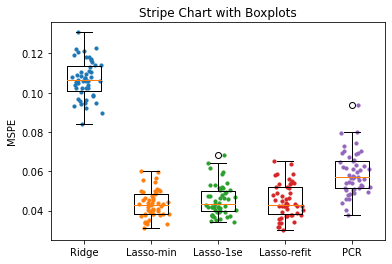

In [15]:
data2 = pd.read_csv("mspe_case2.csv")
labels2 = ['Ridge', 'Lasso-min', 'Lasso-1se', 'Lasso-refit', 'PCR']

fig2, ax2 = plt.subplots()

# Plot stripe charts for each set
for i in range(5):
    plt.scatter(x0+i, data2_convert[:,i], marker='o', s = 10)
plt.boxplot(data2_convert,vert=True)

ax2.set_ylabel('MSPE')
ax2.set_xticks(range(1,6))
ax2.set_xticklabels(labels2[0:5])
ax2.set_title('Stripe Chart with Boxplots')

plt.show()

In [16]:
mean_mspe_case2 = data2_convert.mean(0)
print(mean_mspe_case2)
std_mspe_case2 = data2_convert.std(0)
print(std_mspe_case2)

[0.10679925 0.04342793 0.04536705 0.04492143 0.05884208]
[0.0096825  0.00688827 0.00782473 0.00844662 0.01064482]


#### 1. Which procedure or procedures yield the best performance in terms of MSPE?
According to the stripe chart and the means and standard deviations of MSPE, the Lasso-min yields the best performance.

#### 2. Conversely, which procedure or procedures show the poorest performance?
The full model exhibits the poorest performance, as clearly depicted in the figure, where the MSPE of the full model is notably larger than that of the others.

#### 3. Have you observed any procedure or procedures that performed well in Case I but exhibited poorer performance in Case II, or vice versa? If so, please offer an explanation.
The most obvious example is ridge. In case I, Ridge's predictive performance is on par with that of Lasso (and PCR), boasting a mean MSPE of 0.035. However, in case II, Ridge's mean MSPE increases significantly to 0.107, diverging from Lasso (and PCR).
Ridge does not force any coefficients to be exactly zero. Instead, it shrinks the coefficients towards zero but typically retains all features in the model. In contrast, Lasso can drive some coefficients to exactly zero, effectively removing the corresponding features from the model. Therefore, Ridge works well when multicollinearity is a concern (case I), but in the case where only a subset of the features is relevant (case II), Lasso performs better.


#### 4. Given that Coding2_Data3.csv includes all features found in Coding2_Data2.csv, one might anticipate that the best MSPE in Case II would be equal to or lower than the best MSPE in Case I. Do your simulation results corroborate this expectation? If not, please offer an explanation.
Regarding MSPE, my simulation results do not align with the anticipation. 
(1) The majority of the variation in the dataset Coding2_Data3.csv is attributed to noise, which can potentially amplify the problem of overfitting in regression analysis. 
(2) When noise is present, there exists a trade-off between bias and variance. Noise-induced predictors can intensify this trade-off by inflating the model's variance. 
(3) Additionally, the dimensionality of the regression model exceeds the available number of observations, resulting in decreased informativeness, reducing the accuracy of the model.

# Part One

In [17]:
import statistics as stat

In [18]:
myData_part1 = pd.read_csv("Coding2_Data.csv")
var_names = myData_part1.columns
y_part1 = myData_part1[['Y']].to_numpy()
X_part1 = myData_part1.drop(['Y'], axis = 1).to_numpy()
X_part1.shape, len(y_part1)

((506, 13), 506)

In [19]:
def one_var_lasso(v, x, lam):
    nv = len(v)
    alpha = np.dot(v,x)/(np.linalg.norm(x)**2)
    rho = nv*lam/(np.linalg.norm(x)**2)
    if alpha > rho:
        return(alpha-rho)
    elif alpha < -rho:
        return(alpha + rho)
    else:
        return 0.0
    
def MyLasso(X_input, y_input, lam_seq, maxit):
    
    # Input
    # X: n-by-p design matrix without the intercept 
    # y: n-by-1 response vector 
    # lam.seq: sequence of lambda values (arranged from large to small)
    # maxit: number of updates for each lambda 
    
    # Output
    # B: a (p+1)-by-len(lam.seq) coefficient matrix with the first row being the intercept sequence 
    
    X = X_input
    n, p = X.shape
    nlam = len(lam_seq)
    B = np.zeros((p+1, nlam))
    y = y_input.reshape(n,) # (506,)

    
    # Standardize X by centering and scaling each column 
    meanX = X.mean(0) # meanX = mean of each column, [1, 13]
    stdX = X.std(0) # stdX = standard deviation of each column, [1, 13]
    newX = (X-meanX)/stdX # [506, 13]
    
    # Initilize coef vector b and residual vector v
    b = np.zeros(p)
#    v = y
    
    count = 0
    meanY = y.mean(0) # (1,)
    
    # Triple nested loop
    for m in range(nlam):
        b = np.zeros(p)
        #v = y
        for step in range(maxit):
            for j in range(p):
                X_j = newX[:, j].reshape(n,)  # (506,)
                yp = np.dot(newX, b).reshape(n,) # (506,13)*(13,) = (506,)
                v = y - yp + X_j * b[j]  # (506,)-(506,)+(506,)=(506,)
                b[j] = one_var_lasso(v, X_j, lam_seq[m]) 
        B[1:, m] = b / stdX #+ meanX # b:(13,), std(13,)
        B[0, m] = meanY - np.dot(meanX, B[1:, m])
    
    return(B)


(14, 80)


(-8.35, -0.6499999999999999, -0.30999368240557257, 0.4997421559471155)

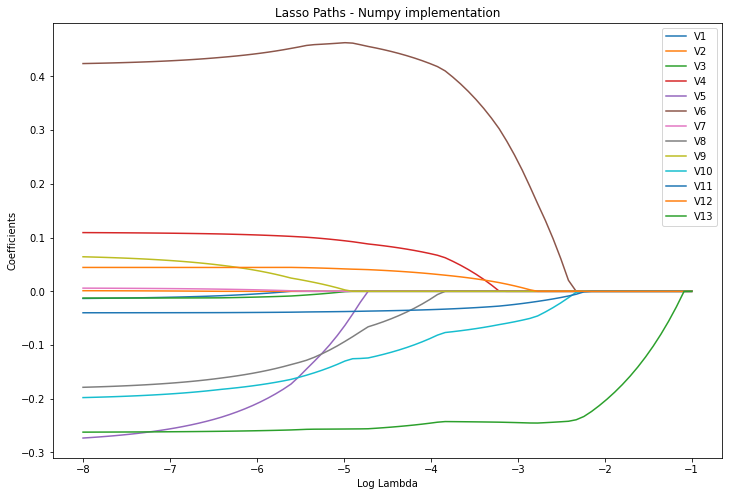

In [20]:
log_lam_seq = np.linspace(-1, -8, num = 80)
lam_seq = np.exp(log_lam_seq)
myout = MyLasso(X_part1, y_part1, lam_seq , maxit = 100)

p, _ = myout.shape
print(myout.shape)
plt.figure(figsize = (12,8))

for i in range(p-1):
    plt.plot(log_lam_seq, myout[i+1, :], label = var_names[i])

#plt.plot(np.ones(13)*(-1),meanX,'*')
    
plt.xlabel('Log Lambda')
plt.ylabel('Coefficients')
plt.title('Lasso Paths - Numpy implementation')
plt.legend()
plt.axis('tight')

In [21]:
lasso_coef = pd.read_csv("Coding2_lasso_coefs.csv").to_numpy()
print(lasso_coef.shape)
print(abs(myout - lasso_coef).max())

(14, 80)
0.0046473537321949365
